In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from plot_field import generate_afl_oval
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

chains_2023 =  pd.read_csv("../data/chains_data.csv")

## Rename columns
chains_2023.rename(columns={'homeTeam.teamName': "homeTeam",
  'awayTeam.teamName': "awayTeam",
  'homeTeamScore.totalScore': 'homeTeamScore',
  'awayTeamScore.totalScore': 'awayTeamScore',
  'chain_number': "chainNumber",
  'venue.name': "venueName",
  'team': "playingFor"}, inplace=True)

# Create columns fr grouping for easy summarising

game_identifiers = ['season', 'roundNumber', 'homeTeam']
chain_identifiers = game_identifiers + ['chainNumber']
possession_identifiers = chain_identifiers + ['possessionNum']

# Remove Kick Into F50 type results
chains_2023 = chains_2023[~chains_2023.description.isin(['Kick Into F50','Kick Inside 50 Result', 'Inside 50'])]

chains_2023['x_norm'] = chains_2023['x'] / (chains_2023['venueLength'] / 2)
## The average ratio of width/length in the league is about 0.78 or so, round up to 0.8
chains_2023['y_norm'] = chains_2023['y'] / (chains_2023['venueWidth'] / 2) * 0.8
chains_2023.fillna({'playerId': 'CONTEXT'}, inplace=True)

# Create number for each possession
chains_2023['possessionNum'] = chains_2023.groupby(["roundNumber", "homeTeam", "period", "chainNumber"],  group_keys=False)['playerId'].apply(lambda s: s.ne(s.shift()).cumsum())
# Create ID for chains and possession for easy lookup
chains_2023['chainId'] = chains_2023.season.astype(str) + "_" + chains_2023.roundNumber.astype(str) + "_" + chains_2023.homeTeam.apply(lambda x: x.replace(" ", "_")) + "_C" + chains_2023.chainNumber.astype(str)
chains_2023['possessionId'] = chains_2023['chainId'] + "_P" + chains_2023.possessionNum.astype(str)

# Identify duplicate rows that show the player gaining possession and remove 
dupes = chains_2023.duplicated(subset=['season', 'roundNumber', 'homeTeam', 'period', 'periodSeconds', 'playerId', 'description'], keep='last')
chains_2023 = chains_2023[~dupes]

# Create of column of instances of possession changes
chains_2023['possChng'] = chains_2023.groupby(game_identifiers + ['period'],  group_keys=False)['playingFor'].apply(lambda s: s.ne(s.shift(-1)))

# Create 
player_info = chains_2023[['playerId', 'firstName', 'surname', 'playingFor']].drop_duplicates().dropna()
player_info['full_name'] = chains_2023['firstName'] + " " + chains_2023['surname']
player_info.drop(['firstName', 'surname'], axis=1, inplace=True)
# player_info.set_index('playerId', inplace=True)

In [252]:
## Create possession summary

def paste(outcm_strings):
    return ', '.join(outcm_strings)

def count_bounce(x):
    return sum(x == "Bounce")

def effective_poss(x):
    return sum(x=="effective")

def calc_dist(x0, y0, x1, y1):
    x0 = np.array(x0, dtype=float)
    y0 = np.array(y0, dtype=float)
    x1 = np.array(x1, dtype=float)
    y1 = np.array(y1, dtype=float)
    return np.sqrt((x1-x0)**2 + (y1 - y0)**2)

def make_list(x):
    return list(x)

def check_final_disposal(x):
    return len(x) - np.argmax(np.flip(x.isin(['Kick', 'Handball', 'Ground Kick']).values)) - 1

possession_summary = (chains_2023
                        .groupby(['season', 'roundNumber', 'chainId', 'possessionId', 'possessionNum', 'playerId','playingFor', 'venueName', 'venueLength', 'venueWidth'])
                        .agg(
                            n=('x', 'size'),
                            outcomes=('description', paste),
                            xInitialPoss = ('x', 'first'),
                            yInitialPoss = ('y', 'first'),
                            xFinalPoss = ('x', 'last'),
                            yFinalPoss = ('y', 'last'),
                            posStart = ('periodSeconds', 'first'),
                            posEnd = ('periodSeconds', 'last'),
                            bounces = ('description', count_bounce),
                            possChng = ('possChng', 'any'),
                            disposal=('disposal', effective_poss),
                            disposalList = ('description', make_list),
                            xList = ('x', make_list),
                            yList = ('x', make_list),
                            finalDisposal = ('description', check_final_disposal),
                            chainInitialState = ('initialState', 'first'),
                            chainFinalState = ('finalState', 'first'),
                            initialState = ('description', 'first'),
                            finalState = ('description', 'last'))).reset_index()

# Update final disposal characteristics when not the final event
for index, row in possession_summary.iterrows():
    if row.finalDisposal + 1 < row.n:
        possession_summary.loc[index, 'finalDisposal'] = row.disposalList[row.finalDisposal]
        possession_summary.loc[index, 'xFinalPoss'] = row.xList[row.finalDisposal]
        possession_summary.loc[index, 'yFinalPoss'] = row.yList[row.finalDisposal]

possession_summary = possession_summary.assign(distanceFromPoss = calc_dist(possession_summary.xInitialPoss, possession_summary.yInitialPoss, possession_summary.xFinalPoss, possession_summary.yFinalPoss),
                        distanceDisposal = calc_dist(possession_summary.xFinalPoss, possession_summary.yFinalPoss, possession_summary.xInitialPoss.shift(-1), possession_summary.yInitialPoss.shift(-1), ),
                        initialDistFromGoal = calc_dist(possession_summary.xInitialPoss, possession_summary.yInitialPoss, possession_summary.venueLength, 0),
                        finalDistFromGoal = calc_dist(possession_summary.xFinalPoss, possession_summary.yFinalPoss, possession_summary.venueLength, 0),
                        disposalRecipient = np.where(~possession_summary.possChng & possession_summary.disposal > 0, possession_summary.playerId.shift(-1),"ieff"))

possession_summary['deltaDistFromGoal'] = possession_summary.finalDistFromGoal - possession_summary.initialDistFromGoal
possession_summary.drop(['venueLength','venueWidth'], axis=1, inplace=True)

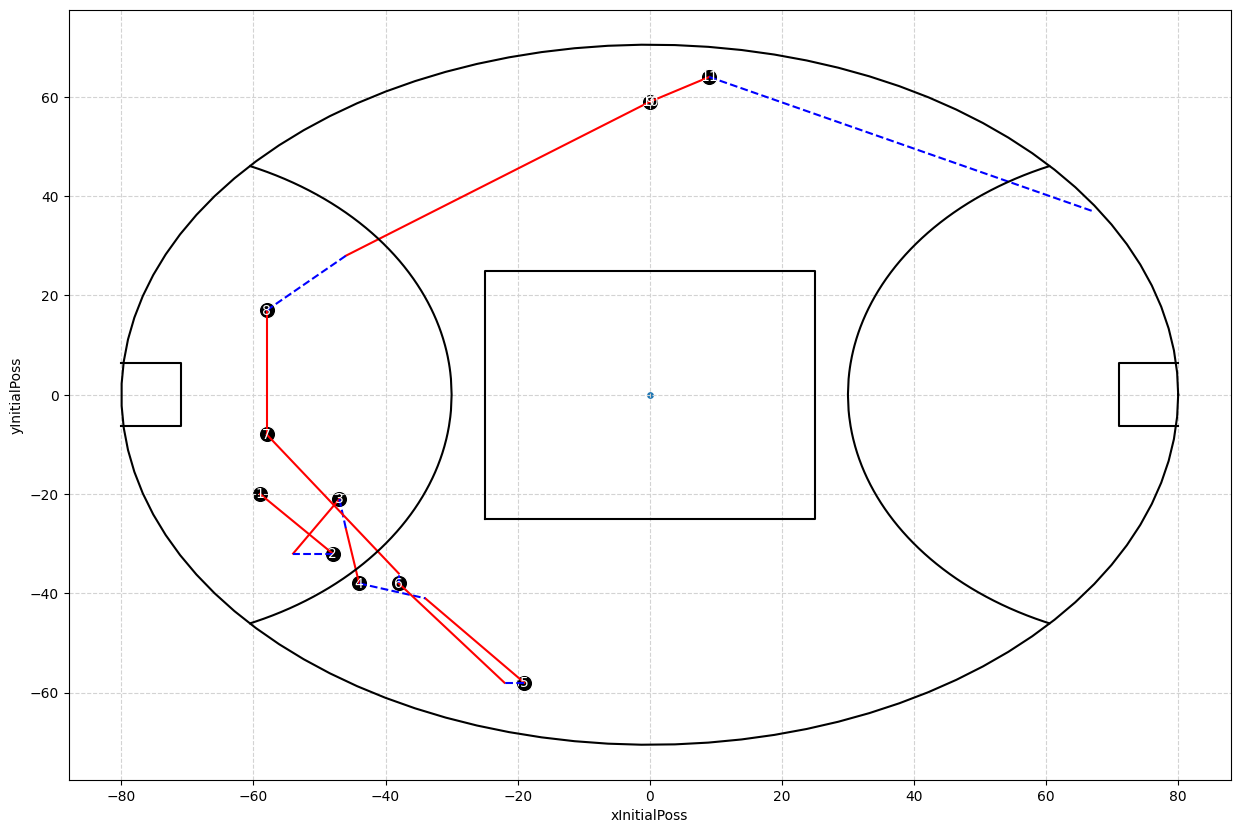

In [108]:
import seaborn as sns

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), color='white', verticalalignment='center', horizontalalignment='center')



## Sanity check - check what the largest change in position was wrt the goals
# chain_sample = possession_summary.sort_values('deltaDistFromGoal', ascending=True).head(100).sample(1)

plot_df = possession_summary[possession_summary.chainId.isin(chain_sample.chainId.values)].sort_values('possessionNum').copy()
plot_df = plot_df.assign(xNextPos = plot_df.xInitialPoss.shift(-1),
                        yNextPos = plot_df.yInitialPoss.shift(-1))
# plot_df = pd.wide_to_long(plot_df, stubnames=['x', 'y'], i=['possessionNum'], j='state', suffix=r'\w+').reset_index()
plot_df_wide = pd.wide_to_long(plot_df, stubnames=['x', 'y'], i=['possessionNum'], j='state', suffix=r'\w+').reset_index()
plt.figure(figsize=(15,10))
for _, rows in plot_df.iterrows():
    x = (rows.xFinalPoss, rows.xNextPos)
    y = (rows.yFinalPoss, rows.yNextPos)
    plt.plot(x, y, 'r-')
    x = (rows.xInitialPoss, rows.xFinalPoss)
    y = (rows.yInitialPoss, rows.yFinalPoss)
    plt.plot(x, y, 'b--')
label_point(plot_df.xInitialPoss, plot_df.yInitialPoss, plot_df.possessionNum, plt.gca())
sns.scatterplot(data=plot_df, x='xInitialPoss', y='yInitialPoss', s=140, c='black')
generate_afl_oval(plot_df.venueName.values[0])
plt.show()

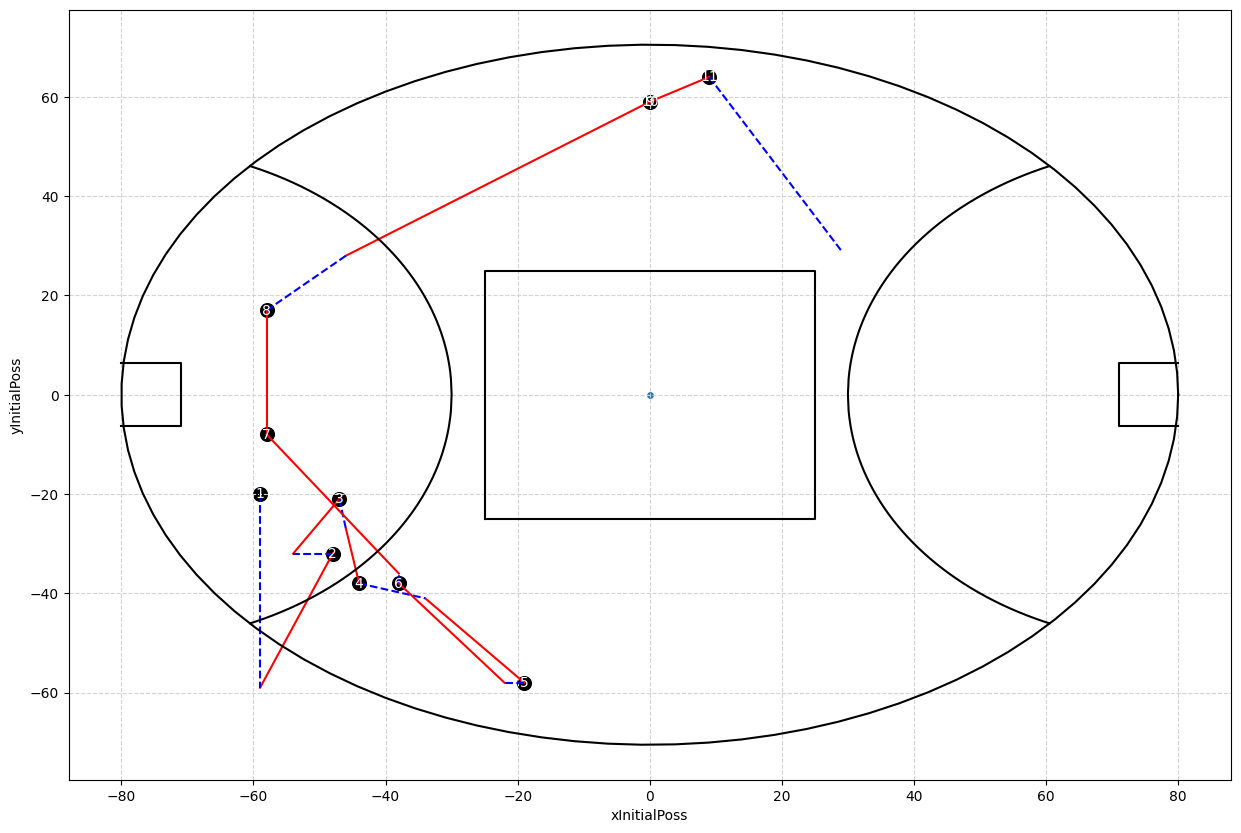

In [256]:
plot_df = possession_summary[possession_summary.chainId.isin(['2023_13_Hawthorn_C147'])].sort_values('possessionNum').copy()
plot_df = plot_df.assign(xNextPos = plot_df.xInitialPoss.shift(-1),
                        yNextPos = plot_df.yInitialPoss.shift(-1))
# plot_df = pd.wide_to_long(plot_df, stubnames=['x', 'y'], i=['possessionNum'], j='state', suffix=r'\w+').reset_index()
plot_df_wide = pd.wide_to_long(plot_df, stubnames=['x', 'y'], i=['possessionNum'], j='state', suffix=r'\w+').reset_index()
plt.figure(figsize=(15,10))
for _, rows in plot_df.iterrows():
    x = (rows.xFinalPoss, rows.xNextPos)
    y = (rows.yFinalPoss, rows.yNextPos)
    plt.plot(x, y, 'r-')
    x = (rows.xInitialPoss, rows.xFinalPoss)
    y = (rows.yInitialPoss, rows.yFinalPoss)
    plt.plot(x, y, 'b--')
label_point(plot_df.xInitialPoss, plot_df.yInitialPoss, plot_df.possessionNum, plt.gca())
sns.scatterplot(data=plot_df, x='xInitialPoss', y='yInitialPoss', s=140, c='black')
generate_afl_oval(plot_df.venueName.values[0])
plt.show()

In [254]:
chain_sample.chainId.values

array(['2023_13_Hawthorn_C147'], dtype=object)

In [142]:
t = chains_2023.copy()
t['nextPlay'] = chains_2023.groupby('possessionId').description.shift(-1)
# 
t[t.description == "Handball"].nextPlay.value_counts()

# t[(t.description == "Kick") & (t.nextPlay == "Loose Ball Get")].sample(1).possessionId


nextPlay
Free For: In Possession    134
Loose Ball Get             131
Hard Ball Get               73
Ground Kick                 36
Free For                    23
Contested Knock On          14
Gather                      13
Tackled By                   6
Rebound 50                   3
Knock On                     1
Free For: Off The Ball       1
No Pressure Error            1
Shepherd                     1
Smothered                    1
Clearance                    1
Handball                     1
Name: count, dtype: int64

In [141]:
chains_2023[chains_2023.possessionId == '2023_1_North_Melbourne_C48_P4']

,season,roundNumber,homeTeam,awayTeam,homeTeamScore,awayTeamScore,date,venueName,venueWidth,venueLength,homeTeamDirectionQtr1,displayOrder,chainNumber,initialState,finalState,period,periodSeconds,playingFor,playerId,firstName,surname,position,description,disposal,shotAtGoal,behindInfo,x,y,x_norm,y_norm,possessionNum,chainId,possessionId,possChng
4379,2023,1,North Melbourne,West Coast Eagles,87,82,2023-03-18,Marvel Stadium,129,160,left,435,48,possGain,behind,1,1611,North Melbourne,CD_I1006058,Bailey,Scott,MIDFIELDER,Uncontested Mark,NaN,NaN,NaN,1,-60,0.0125,-0.744186,4,2023_1_North_Melbourne_C48,2023_1_North_Melbourne_C48_P4,False
4380,2023,1,North Melbourne,West Coast Eagles,87,82,2023-03-18,Marvel Stadium,129,160,left,436,48,possGain,behind,1,1617,North Melbourne,CD_I1006058,Bailey,Scott,MIDFIELDER,Kick,ineffective,NaN,NaN,6,-58,0.0750,-0.719380,4,2023_1_North_Melbourne_C48,2023_1_North_Melbourne_C48_P4,False
4381,2023,1,North Melbourne,West Coast Eagles,87,82,2023-03-18,Marvel Stadium,129,160,left,437,48,possGain,behind,1,1622,North Melbourne,CD_I1006058,Bailey,Scott,MIDFIELDER,Loose Ball Get,NaN,NaN,NaN,27,-45,0.3375,-0.558140,4,2023_1_North_Melbourne_C48,2023_1_North_Melbourne_C48_P4,False
4382,2023,1,North Melbourne,West Coast Eagles,87,82,2023-03-18,Marvel Stadium,129,160,left,438,48,possGain,behind,1,1622,North Melbourne,CD_I1006058,Bailey,Scott,MIDFIELDER,Handball,effective,NaN,NaN,31,-42,0.3875,-0.520930,4,2023_1_North_Melbourne_C48,2023_1_North_Melbourne_C48_P4,False


In [ ]:
## Sanity check - visualise a possession
df = chains_2023[(chains_2023.roundNumber == 1) & (chains_2023['homeTeam'] == "Richmond") & (chains_2023.period == 1) & (chains_2023.chainNumber == 2)]
df
# plt.scatter('x', 'y', c='chainNumber', data=df)

In [ ]:
# Create pass networks - subset the possession summary and join on player names

pass_network = possession_summary[['season', 'roundNumber', 'possessionId','playingFor', 'playerId','disposalRecipient', 'finalState']].merge(player_info, on='playerId', how='inner')
pass_network = pass_network.merge(player_info, left_on='disposalRecipient', right_on='playerId', how='inner', suffixes=['_disposer','_reciever'])

# Count interations
pass_network.groupby(['playingFor']).value_counts(['full_name_disposer', 'full_name_reciever', 'finalState']).sort_values(ascending=False).head(40)

In [212]:
# Find last disposal and gather info after it

t= (chains_2023
     .head(100)
    .groupby('possessionId')
    .description
    .agg(finalDisposal = lambda s: len(s) - np.argmax(np.flip(s.isin(['Kick', 'Handball', 'Ground Kick']).values)) - 1,
         possessionCount = lambda s: len(s)))
#     .query('(finalDisposal < possessionCount) & (finalDisposal > 0)'))
t

,finalDisposal,possessionCount
possessionId,,
2023_1_Richmond_C10_P1,1,2
2023_1_Richmond_C10_P2,0,1
2023_1_Richmond_C11_P1,0,1
2023_1_Richmond_C12_P1,1,2
2023_1_Richmond_C12_P2,1,2
...,...,...
2023_1_Richmond_C8_P3,0,1
2023_1_Richmond_C8_P4,1,2
2023_1_Richmond_C8_P5,0,1


In [205]:
# a = pd.Series(['Mark Fumbled', 'Gather', 'Kick'])
# np.argmax(np.flip(a.isin(['Kick', 'Handball', 'Ground Kick'])))
t.assign(x=t.possessionCount - t.finalDisposal).sort_values('x',ascending=False)

,finalDisposal,possessionCount,x
possessionId,,,
2023_18_Carlton_C238_P7,2,4,2
2023_3_Fremantle_C150_P8,2,4,2
2023_3_Collingwood_C76_P1,2,4,2
2023_17_Essendon_C211_P2,2,4,2
2023_6_Port_Adelaide_C26_P4,3,5,2
...,...,...,...
2023_16_Western_Bulldogs_C44_P7,2,3,1
2023_16_Western_Bulldogs_C36_P2,2,3,1
2023_16_Western_Bulldogs_C31_P3,2,3,1


In [210]:
chains_2023[chains_2023.possessionId == '2023_1_Richmond_C10_P1']

,season,roundNumber,homeTeam,awayTeam,homeTeamScore,awayTeamScore,date,venueName,venueWidth,venueLength,homeTeamDirectionQtr1,displayOrder,chainNumber,initialState,finalState,period,periodSeconds,playingFor,playerId,firstName,surname,position,description,disposal,shotAtGoal,behindInfo,x,y,x_norm,y_norm,possessionNum,chainId,possessionId,possChng
65,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,right,66,10,possGain,ballUpCall,1,241,Carlton,CD_I1000953,Harry,McKay,KEY_FORWARD,Loose Ball Get,NaN,NaN,NaN,54,-5,0.6750,-0.056738,1,2023_1_Richmond_C10,2023_1_Richmond_C10_P1,False
66,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,right,67,10,possGain,ballUpCall,1,241,Carlton,CD_I1000953,Harry,McKay,KEY_FORWARD,Handball,ineffective,NaN,NaN,55,-5,0.6875,-0.056738,1,2023_1_Richmond_C10,2023_1_Richmond_C10_P1,True
